<a href="https://colab.research.google.com/github/Abhishek-IITH/Projects/blob/main/Lane_detection/sm20mtech12012_DL4V_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [ ]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [ ]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



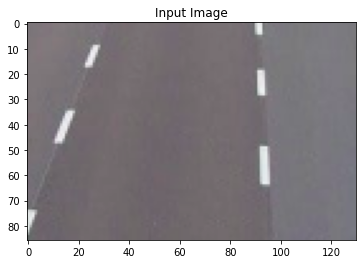

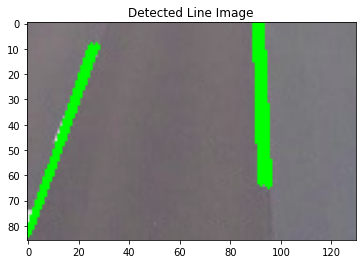

[90  0 92 63]


In [ ]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####
'''lines = cv2.HoughLines(edges,1,np.pi/180, 200)
for r,theta in lines[0:200]: 
  p = np.cos(theta)
  q = np.sin(theta) 
  x0 = p*r
  y0 = q*r
  # round off the following values
  x1 = int(x0 + 1000*(-q))      
  y1 = int(y0 + 1000*(p)) 
  x2 = int(x0 - 1000*(-q)) 
  y2 = int(y0 - 1000*(p)) 
  cv2.line(img,(x1,y1), (x2,y2), (0,0,255),2)'''


lines = cv2.HoughLinesP(edges,1,np.pi/180,15,None,minLineLength=60,maxLineGap=250)
if lines is not None:
  for i in range(0, len(lines)):
    l = lines[i][0]
    cv2.line(img, (l[0], l[1]), (l[2], l[3]), (0,255,0), 2)


#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()
print(l)

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [ ]:
import numpy as np
np.random.seed(0)
import math

# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(out_rate*num_points) 
        inliers = int(np.ceil((1-out_rate)*num_points))
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = ((A@points_s) + t)[:,:inliers]
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####
        x1,x2,x3= points_s[0, :, 0]
        y1,y2,y3= points_s[1, :, 0]
        x1_t,x2_t,x3_t= points_t[0, :,0]
        y1_t,y2_t,y3_t= points_t[1, :,0]
        
        M= [[x1,y1,0,0,1,0],
            [0,0,x1,y1,0,1],
            [x2,y2,0,0,1,0],
            [0,0,x2,y2,0,1],
            [x3,y3,0,0,1,0],
            [0,0,x3,y3,0,1],]

        b=[x1_t,y1_t,x2_t,y2_t,x3_t,y3_t]
        theta,res,rank,s= np.linalg.lstsq(M,b,rcond=None) 
        A=np.array([[theta[0],theta[1]], [theta[2],theta[3]]])
        t=np.array([[theta[4]],[theta[5]]])

        return A, t

        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE

        points_l = np.zeros((points_s.shape[0],points_s.shape[1]))
        points_l = A@points_s + t
        # for i in range(points_s.shape[1]):
        #   points_l[0,i] = ((A * points_s[:,i]) + t)[0,0]
        residual = np.zeros(points_s.shape[1])
        
        for i in range(points_l.shape[1]):
          residual[i] = math.hypot(points_t[0,i] - points_l[0,i], points_t[1,i] - points_l[1,i])

        return residual
    
        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimateda ffine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        residual = A_rsc = t_rsc = 0
       
        for i in range(ITER_NUM):
          idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
          A_i, t_i = tf.affine_transformation(points_s[:, idx], points_t[:, idx])
          temp = self.calculate_distance(A_i,t_i,points_s,points_t)
          if residual<(temp<self.thr).sum():
            residual = (temp<self.thr).sum()
            A_rsc = A_i
            t_rsc = t_i
            inliers = np.where(temp<self.thr)

        return A_rsc, t_rsc, inliers

        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)


(101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



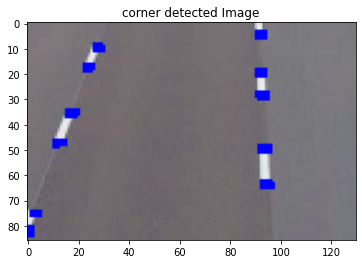

Total corners detected:  222


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy,cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)

## STEP 2: Detect corners 
cd = cv2.cornerHarris(gray,2,3,0.04)

## STEP 3: Dilate corner image to enhance corner points
cd_f = cv2.dilate(cd,None)

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
image[cd_f>0.1*cd_f.max()]=[0,0,255]

## STEP 5: Count number of detected corner points and draw them on the image
count=0
for i in range(cd.shape[0]):
    for j in range(cd.shape[1]):
        if int(cd_f[i,j]) > 0.1*cd_f.max():
            count+=1

plt.imshow(image)
plt.title('corner detected Image')
plt.show()
print('Total corners detected: ',count)
### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [ ]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
# define a transforms for preparing the dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307), (0.3081))])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

cuda


In [ ]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
#### YOUR CODE ENDS HERE ####

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,
                                         shuffle=False)

#### YOUR CODE ENDS HERE ###


### Network Definition

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3,stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3 , stride=1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2, 2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(11*11*64, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)

        #### YOUR CODE ENDS HERE ####
         
    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out=F.relu(self.conv1(x))
        out=F.relu(self.conv2(out))
        out=F.relu(self.conv3(out))
        out = self.pool(out)
        #out=self.maxpool(out)
        out=self.dropout1(out)
        out = out.view(out.shape[0], -1)
        out=self.fc1(out)
        out = F.relu(out)
        out=self.dropout2(out)
        out=self.fc2(out)


        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [ ]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_loader.batch_size == 32)
        self.assertTrue(test_loader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 9.699s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target= data.cuda(),target.cuda()
        #images = images.view(-1, 28*28).requires_grad_().to(device)
        
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = net(data)
        # calculate the loss (use nll_loss in pytorch)
        loss=F.nll_loss(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target= data.cuda(),target.cuda()
            #images = images.view(-1, 28*28).requires_grad_().to(device)
            # pass the image to the model and assign the output to variable named output
            output=net(data)
            test_loss +=target.size(0) # sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            pred = torch.argmax(output.data, 1)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [ ]:
net=Net()
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

#test(net,device,test_loader)
n_epochs=26
for epoch in range(1, n_epochs):
  train(net,device,train_loader,optimizer, epoch)

test(net,device,test_loader)

#x = x.view(x.shape[0], -1)
#train(net,device,train_loader,optimizer,25)        

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300935
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.800083
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.214902
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.554857
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.652123
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.727423
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.584590
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.566054
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.435795
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.431151
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.822570
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.229649
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.575560
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.436694
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.178608
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.520798
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.786699
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.276769
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.409462
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.564743
Train Epoch: 1 [12800/60000 (

Using Adam optimizer and ReLu activation, we got following results:

Accuracy: 99.36% ,Loss:0.64%

### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3,stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3 , stride=1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2, 2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(11*11*64, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)

        #### YOUR CODE ENDS HERE ####
         
    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out=F.sigmoid(self.conv1(x))
        out=F.sigmoid(self.conv2(out))
        out=F.sigmoid(self.conv3(out))
        out = self.pool(out)
        #out=self.maxpool(out)
        out=self.dropout1(out)
        out = out.view(out.shape[0], -1)
        out=self.fc1(out)
        out = F.sigmoid(out)
        out=self.dropout2(out)
        out=self.fc2(out)


        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output


net=Net()
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

#test(net,device,test_loader)
n_epochs=26
for epoch in range(1, n_epochs):
  train(net,device,train_loader,optimizer, epoch)
  test(net,device,test_loader)




/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325409
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.444530
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.352903
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.286955
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.270715
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.317314
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.390921
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.316528
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.297117
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.308017
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.339805
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.297252
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.269623
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.317979
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.275493
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.261622
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.195967
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.983820
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.571654
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.459726
Train Epoch: 1 [12800/60000 (

Using sigmoid activation we got 99.08% test accuracy that is a little drop in accuracy than ReLu activation because of some following reasons:

1.Vanishing gradients i.e, derivative of sigmoid is always smaller than 1.

2.Due to many hidden layers, these small gradients value make neurons to be tending to zero.

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3,stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3 , stride=1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2, 2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(11*11*64, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)

        #### YOUR CODE ENDS HERE ####
         
    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out=F.relu(self.conv1(x))
        out=F.relu(self.conv2(out))
        out=F.relu(self.conv3(out))
        out = self.pool(out)
        #out=self.maxpool(out)
        out=self.dropout1(out)
        out = out.view(out.shape[0], -1)
        out=self.fc1(out)
        out = F.relu(out)
        out=self.dropout2(out)
        out=self.fc2(out)


        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

net=Net()
net.cuda()
optimizer = optim.SGD(net.parameters(), lr=3e-4)

#test(net,device,test_loader)
n_epochs=26
for epoch in range(1, n_epochs):
  train(net,device,train_loader,optimizer, epoch)

test(net,device,test_loader)



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306433
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.313577
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.313777
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.283539
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.309141
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.327810
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.261007
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.266945
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.324449
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.314632
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.307012
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.254499
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.257264
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.236520
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.292126
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.272338
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.293543
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.218566
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.219186
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.251678
Train Epoch: 1 [12800/60000 (

Instead of Adam optimizer I have used SGD ( stochastic gradient descent ) as a optimizer which gives 96.53% test accuracy (lower than previous) because of little high learning rate (3e^-4= 0.0549...)but with 0.01 (lower learning rate ) SGD will converge faster than Adam, but here in my case SGD gives less accuracy than Adam.

Hence, in overall performance Adam gives best test accuracy than SGD optimizer.

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3,stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3 , stride=1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2, 2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(11*11*64, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        
        self.initialize_weights()
        #### YOUR CODE ENDS HERE ####
         
    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out=F.relu(self.conv1(x))
        out=F.relu(self.conv2(out))
        out=F.relu(self.conv3(out))
        out = self.pool(out)
        #out=self.maxpool(out)
        out=self.dropout1(out)
        out = out.view(out.shape[0], -1)
        out=self.fc1(out)
        out = F.relu(out)
        out=self.dropout2(out)
        out=self.fc2(out)


        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

    def initialize_weights(self):
          for m in self.modules():
            if isinstance(m,nn.Conv2d):
              nn.init.constant_(m.weight,1)
              nn.init.constant_(m.bias,1)        

net=Net()
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

n_epochs=26
for epoch in range(1, n_epochs):
  train(net,device,train_loader,optimizer, epoch)
  test(net,device,test_loader)

  


Train Epoch: 1 [0/60000 (0%)]	Loss: 267559.218750
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.244166
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.304570
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.217761
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.306576
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.301230
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.312833
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.303802
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.313767
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.299841
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.309417
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.297514
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.299060
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.302718
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.310890
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.302235
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.309742
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.292289
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.306037
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.313546
Train Epoch: 1 [12800/60

Here, due to slow learning rate and initialized weights and biases all ones (1), the test accuracy has decreased drastically that is 11.35%. Model can not learn properly in that scenario.

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3,stride=1)
        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.zeros_(self.conv1.bias)

        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        torch.nn.init.xavier_normal_(self.conv2.weight)
        torch.nn.init.zeros_(self.conv2.bias)

        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3 , stride=1)
        torch.nn.init.xavier_normal_(self.conv3.weight)
        torch.nn.init.zeros_(self.conv3.bias)

        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2, 2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(11*11*64, 128)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.zeros_(self.fc1.bias)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        torch.nn.init.zeros_(self.fc2.bias)

        #### YOUR CODE ENDS HERE ####
         
    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out=F.relu(self.conv1(x))
        out=F.relu(self.conv2(out))
        out=F.relu(self.conv3(out))
        out = self.pool(out)
        #out=self.maxpool(out)
        out=self.dropout1(out)
        out = out.view(out.shape[0], -1)
        out=self.fc1(out)
        out = F.relu(out)
        out=self.dropout2(out)
        out=self.fc2(out)


        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

net=Net()
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

#test(net,device,test_loader)
n_epochs=26
for epoch in range(1, n_epochs):
  train(net,device,train_loader,optimizer, epoch)

test(net,device,test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313998
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.782898
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.057121
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.545673
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.666951
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.732186
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.723669
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.711167
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.366173
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.457721
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.217474
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.161497
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.296936
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.317119
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.199989
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.287416
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.702806
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.452268
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.325261
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.179276
Train Epoch: 1 [12800/60000 (

Using Xavier initialization ,our test accuracy improves a little bit i.e, 99.40% because of using Xavier initialization, the variance across every layer is the same.

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3,stride=1)
        torch.nn.BatchNorm2d(16)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1)
        torch.nn.BatchNorm2d(32)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3 , stride=1)
        torch.nn.BatchNorm2d(64)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2, 2)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(11*11*64, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128,10)

        #### YOUR CODE ENDS HERE ####
         
    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out=F.relu(self.conv1(x))
        out=F.relu(self.conv2(out))
        out=F.relu(self.conv3(out))
        out = self.pool(out)
        #out=self.maxpool(out)
        out=self.dropout1(out)
        out = out.view(out.shape[0], -1)
        out=self.fc1(out)
        out = F.relu(out)
        out=self.dropout2(out)
        out=self.fc2(out)


        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

net=Net()
net.cuda()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

#test(net,device,test_loader)
n_epochs=26
for epoch in range(1, n_epochs):
  train(net,device,train_loader,optimizer, epoch)

test(net,device,test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312485
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.485990
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.097916
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.805189
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.661318
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.344659
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.445734
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.792818
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.298665
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.431172
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.595457
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.128931
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.423864
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.449362
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.423409
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.149147
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.230870
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.143825
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.464722
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.099793
Train Epoch: 1 [12800/60000 (

Here ,I have used 3 BatchNorm layers to the network ,the test accuracy comes out to be 99.41% (best from all of the above ) because of the following reason:

1.Optimization of error function is smoother which leads to better and stable behavior of gradients which further leads to faster training of model.   

# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
